## FCV: HW5
### Name: Amir Hossein Haji Mohammad Rezaie

# Part 1:Canny Edge Detection

Implement Canny Edge Detection from scratch and apply that on Lena.png image. The below steps must be followed in your code. (35 point)
1. Gray scale conversion
2. Noise reduction
3. Gradient calculation
4. Non-maximum suppression
5. Double Thresholding and hysteresis
(You must Define a function and plot the output for each step)

## 1. GrayScale Concersion

In [210]:
import cv2 as cv
import matplotlib.pyplot as plt

img = cv.imread('Lena.png', cv.IMREAD_COLOR)

In [211]:
def convert_gray(img):
    r_coef = 0.2989
    g_coef = 0.5870
    b_coef = 0.1140
    
    return r_coef*img[:, :, 0] + g_coef*img[:, :, 1] + b_coef*img[:, :, 2]

gray = convert_gray(img)

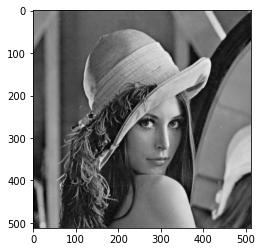

In [212]:
plt.imshow(gray, cmap='gray')

## Noise reduction

In [224]:
import numpy as np

def convolution(oldimage, kernel):
    
    image_h, image_w = oldimage.shape
    
    kernel_h, kernel_w = kernel.shape
        
    image_pad = np.pad(oldimage, pad_width=(
        (kernel_h // 2, kernel_h // 2),(kernel_w // 2, 
        kernel_w // 2)), mode='constant', constant_values=0).astype(np.float32)
    
    
    h = kernel_h // 2
    w = kernel_w // 2
    
    image_conv = np.zeros(image_pad.shape)
    
    for i in range(h, image_pad.shape[0]-h):
        for j in range(w, image_pad.shape[1]-w):
            
            x = image_pad[i-h:i-h+kernel_h, j-w:j-w+kernel_w]
            image_conv[i][j] = (x.flatten()*kernel.flatten()).sum()
        
    h_end = -h
    w_end = -w
    
    if(h == 0):
        return image_conv[h:,w:w_end]
    if(w == 0):
        return image_conv[h:h_end,w:]
    return image_conv[h:h_end,w:w_end]


def GaussianBlurImage(image, sigma):
    # define gaussian filter
    filter_size = 2 * int(4 * sigma + 0.5) + 1
    gaussian_filter = np.zeros((filter_size, filter_size), np.float32)
    m = filter_size//2
    n = filter_size//2
    
    for x in range(-m, m+1):
        for y in range(-n, n+1):
            x1 = 2*np.pi*(sigma**2)
            x2 = np.exp(-(x**2 + y**2)/(2* sigma**2))
            gaussian_filter[x+m, y+n] = (1/x1)*x2
        
    # convolution
    im_filtered = np.zeros_like(image, dtype=np.float32)
    im_filtered[:, :] = convolution(image[:, :], gaussian_filter)
    return (im_filtered.astype(np.uint8))

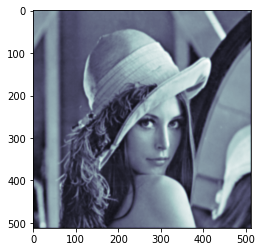

In [225]:
img_blur = GaussianBlurImage(gray, sigma=1.375)

plt.imshow(img_blur, cmap='bone')

## Gradient Calculation

In [226]:
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

sobel_y = sobel_x.T

gaussian_kernel = np.array([[1, 2, 1],
                            [2, 4, 2],
                            [1, 2, 1]])/16

G_x = convolution(img_blur, sobel_x)
G_y = convolution(img_blur, sobel_y)

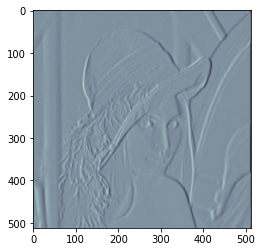

In [227]:
plt.imshow(G_x, cmap='bone')

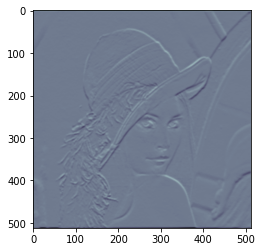

In [228]:
plt.imshow(G_y, cmap='bone')

In [229]:
G = np.hypot(G_x, G_y)

G = G / G.max() * 255 # the total gradient; ie, the edge detection result
theta = np.arctan2(G_y, G_x)

## Non-maximum suppression

In [230]:
M, N = G.shape
Z = np.zeros((M,N), dtype=np.int32) # resultant image
angle = theta * 180. / np.pi        # max -> 180, min -> -180
angle[angle < 0] += 180             # max -> 180, min -> 0

for i in range(1,M-1):
    for j in range(1,N-1):
        q = 255
        r = 255
        
        if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
            r = G[i, j-1]
            q = G[i, j+1]

        elif (22.5 <= angle[i,j] < 67.5):
            r = G[i-1, j+1]
            q = G[i+1, j-1]

        elif (67.5 <= angle[i,j] < 112.5):
            r = G[i-1, j]
            q = G[i+1, j]

        elif (112.5 <= angle[i,j] < 157.5):
            r = G[i+1, j+1]
            q = G[i-1, j-1]

        if (G[i,j] >= q) and (G[i,j] >= r):
            Z[i,j] = G[i,j]
        else:
            Z[i,j] = 0

## Double thresholding and Hystesis

In [231]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    '''
    Double threshold
    '''
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

In [232]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape

    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i, j] == weak):
                if (
                    (img[i+1, j-1] == strong) or (img[i+1, j] == strong) or
                    (img[i+1, j+1] == strong) or (img[i, j-1] == strong) or
                    (img[i, j+1] == strong) or (img[i-1, j-1] == strong) or
                    (img[i-1, j] == strong) or (img[i-1, j+1] == strong)
                ):
                    img[i, j] = strong
                else:
                    img[i, j] = 0
    return img

In [233]:
res, weak, strong = threshold(Z)
final = hysteresis(res, weak)

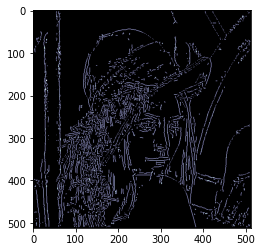

In [234]:
plt.imshow(final, cmap='bone')

# part 2: Harris Corner Detector

First Implement Harris key point detector from scratch and apply that on Harris.png . Second implement Harris using OpenCV and compare the results. (35 point)

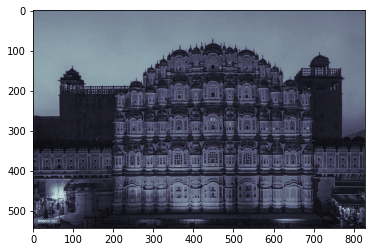

In [235]:
img = cv.imread('Harris.png')
gray = convert_gray(img)

plt.imshow(gray, cmap='bone')

In [105]:
def harris_detector(gray, k, sobel_x=sobel_x, sobel_y=sobel_y, guassian_kernel=gaussian_kernel):
    d_x = convolution(gray, sobel_x)
    d_y = convolution(gray, sobel_y)
    
    A = convolution(d_x*d_x, gaussian_kernel)
    B = convolution(d_y*d_y, gaussian_kernel)
    C = convolution(d_x*d_y, gaussian_kernel)
    
    return (A*B - (C*C)) - k*(A + B)*(A + B)

In [171]:
k = 0.05
thresh = 0.005

# thresholded corner responses
dst = harris_detector(gray, k)

In [172]:
corners = dst > thresh * np.max(dst)

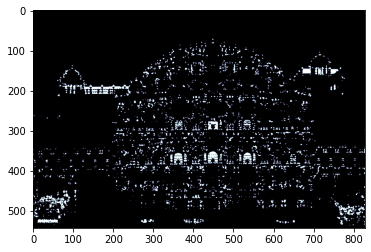

In [173]:
plt.imshow(corners, cmap='bone')

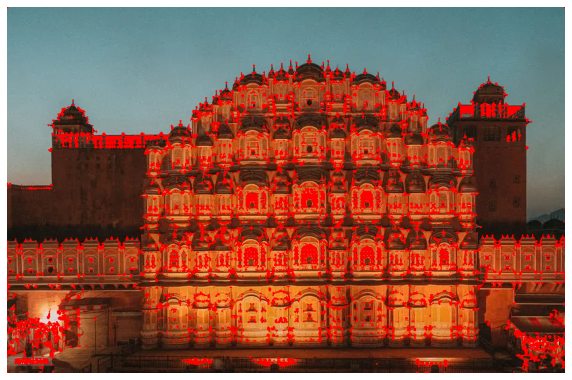

In [174]:
img[corners] = [0, 0, 255]

plt.figure(figsize = [10, 10])
plt.axis('off')
plt.imshow(img[:,:,::-1])

## OpenCV Implementation

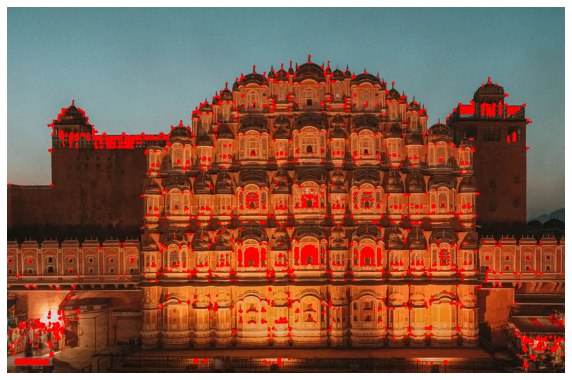

In [175]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('Harris.png')

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)

dst1 = cv2.cornerHarris(gray, 2, 3, 0.04)
dst = cv2.dilate(dst1, None)

image[dst > 0.01 * dst.max()] = [0, 0, 255]

plt.figure(figsize = [10, 10])
plt.axis('off')
plt.imshow(image[:,:,::-1])

# Part 3: MSER 

Perform Maximally Stable Extremal Region (MSER) algorithm on img3.jpg. Find the best hyperparameters to detect all smallest blobs (6 blobs similar to img3_output.jpg). Feel free to use opencv library . You should report the final hyperparameters. (30 point)

best parametes: delta=20, max_area=5500, min_area=2000


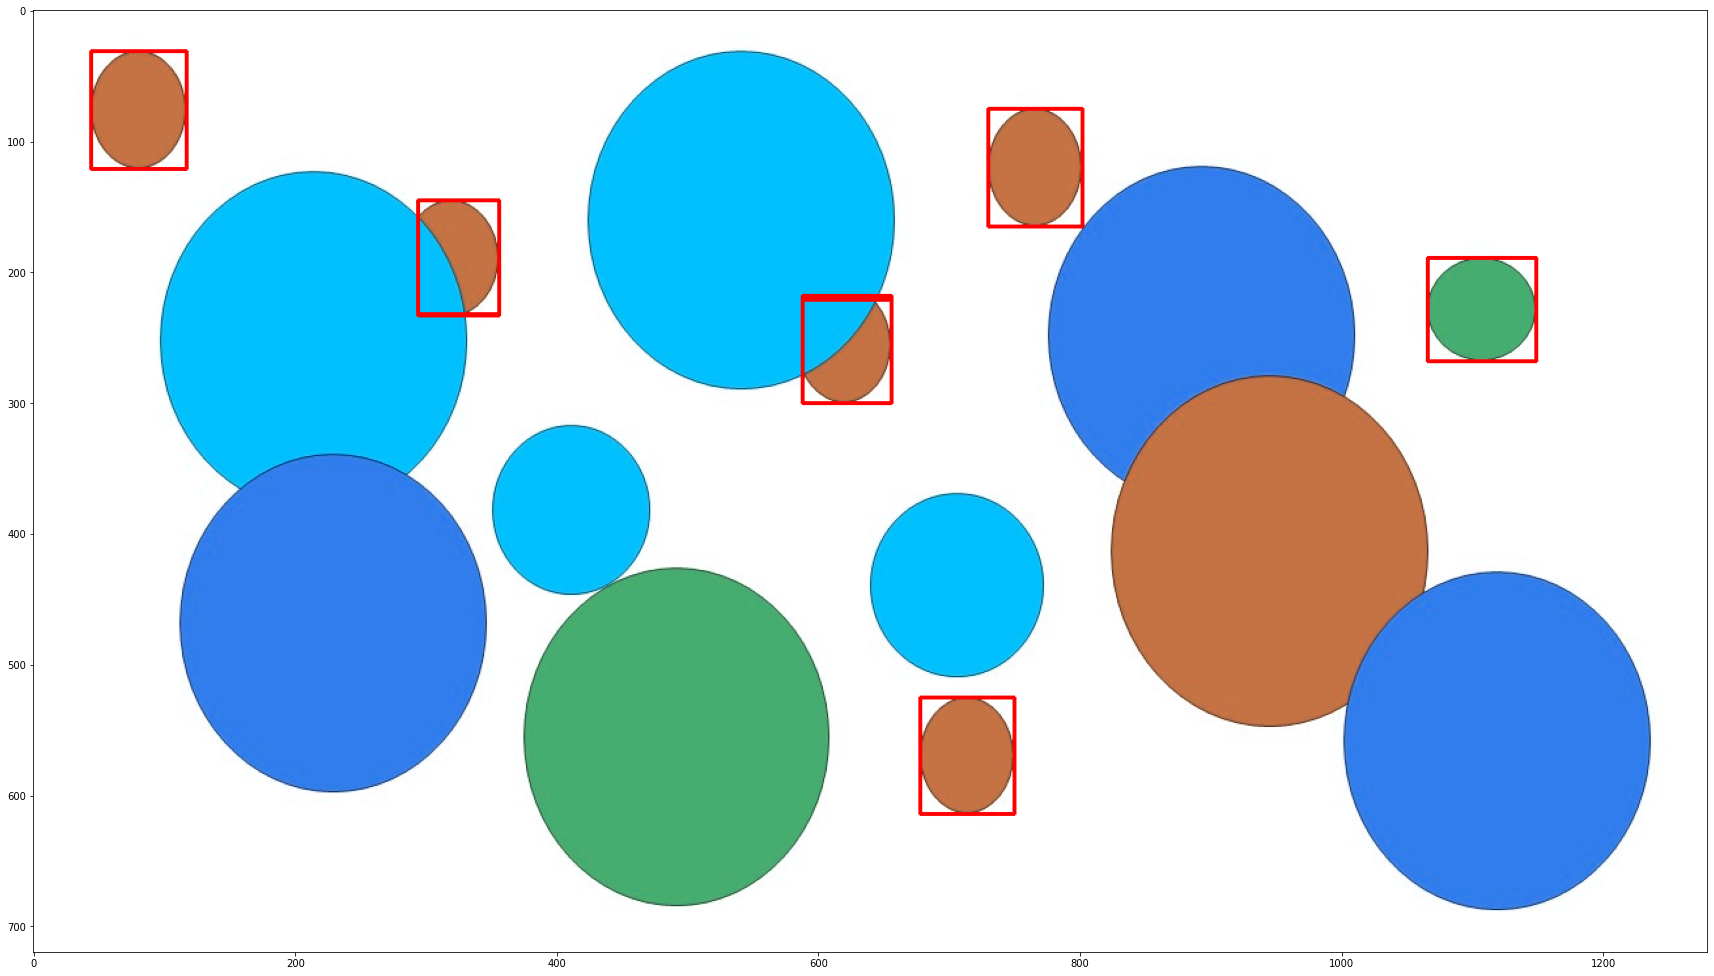

In [237]:
def get_num_regions(img, a, b, c):
    mser = cv2.MSER_create(delta=a, max_area=b, min_area=c)
    regions, _ = mser.detectRegions(img)
    return len(regions)


def plot_results(img, best_parameters):
    a, b, c = best_parameters
    mser = cv2.MSER_create(delta=a, max_area=b, min_area=c)
    regions, boundingBoxes = mser.detectRegions(img)
    
    filtered_regions = [p for p in regions if len(p) > 10]

    img_output = image.copy()
    for p in filtered_regions:
        x, y, w, h = cv2.boundingRect(p.reshape(-1, 1, 2))
        # filter longer boxes
        if h/w > 1.5:
            continue
        cv2.rectangle(img_output, (x, y), (x + w, y + h), (255, 0, 0), 2)

    fig = plt.figure(figsize=(30, 40))
    plt.imshow(img_output)
    
    
    
def finetune_mser():
    image = cv2.imread("img3.jpg")
    # Convert the image to grayscale
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    delta_values = range(20, 30, 2)
    min_area_values = range(2000, 3000, 100)
    max_area_values = range(5000, 7000, 500)
    
    num_regions = None
    parameters = None
    
    for a in delta_values:
        for b in max_area_values:
            for c in min_area_values:
                num = get_num_regions(img, a, b, c)
                
                if num_regions is None or num_regions < num:
                    num_regions = num
                    parameters = (a, b, c)
           
    print(f'best parametes: delta={parameters[0]}, max_area={parameters[1]}, min_area={parameters[2]}')
    plot_results(img, parameters)
    
finetune_mser()

## SIFT features


4. Use SIFT features to match the template.jpg to img4.jpg. Your final results should be same as img4_output.jpg. You can use opencv library. (Extra 20 point)

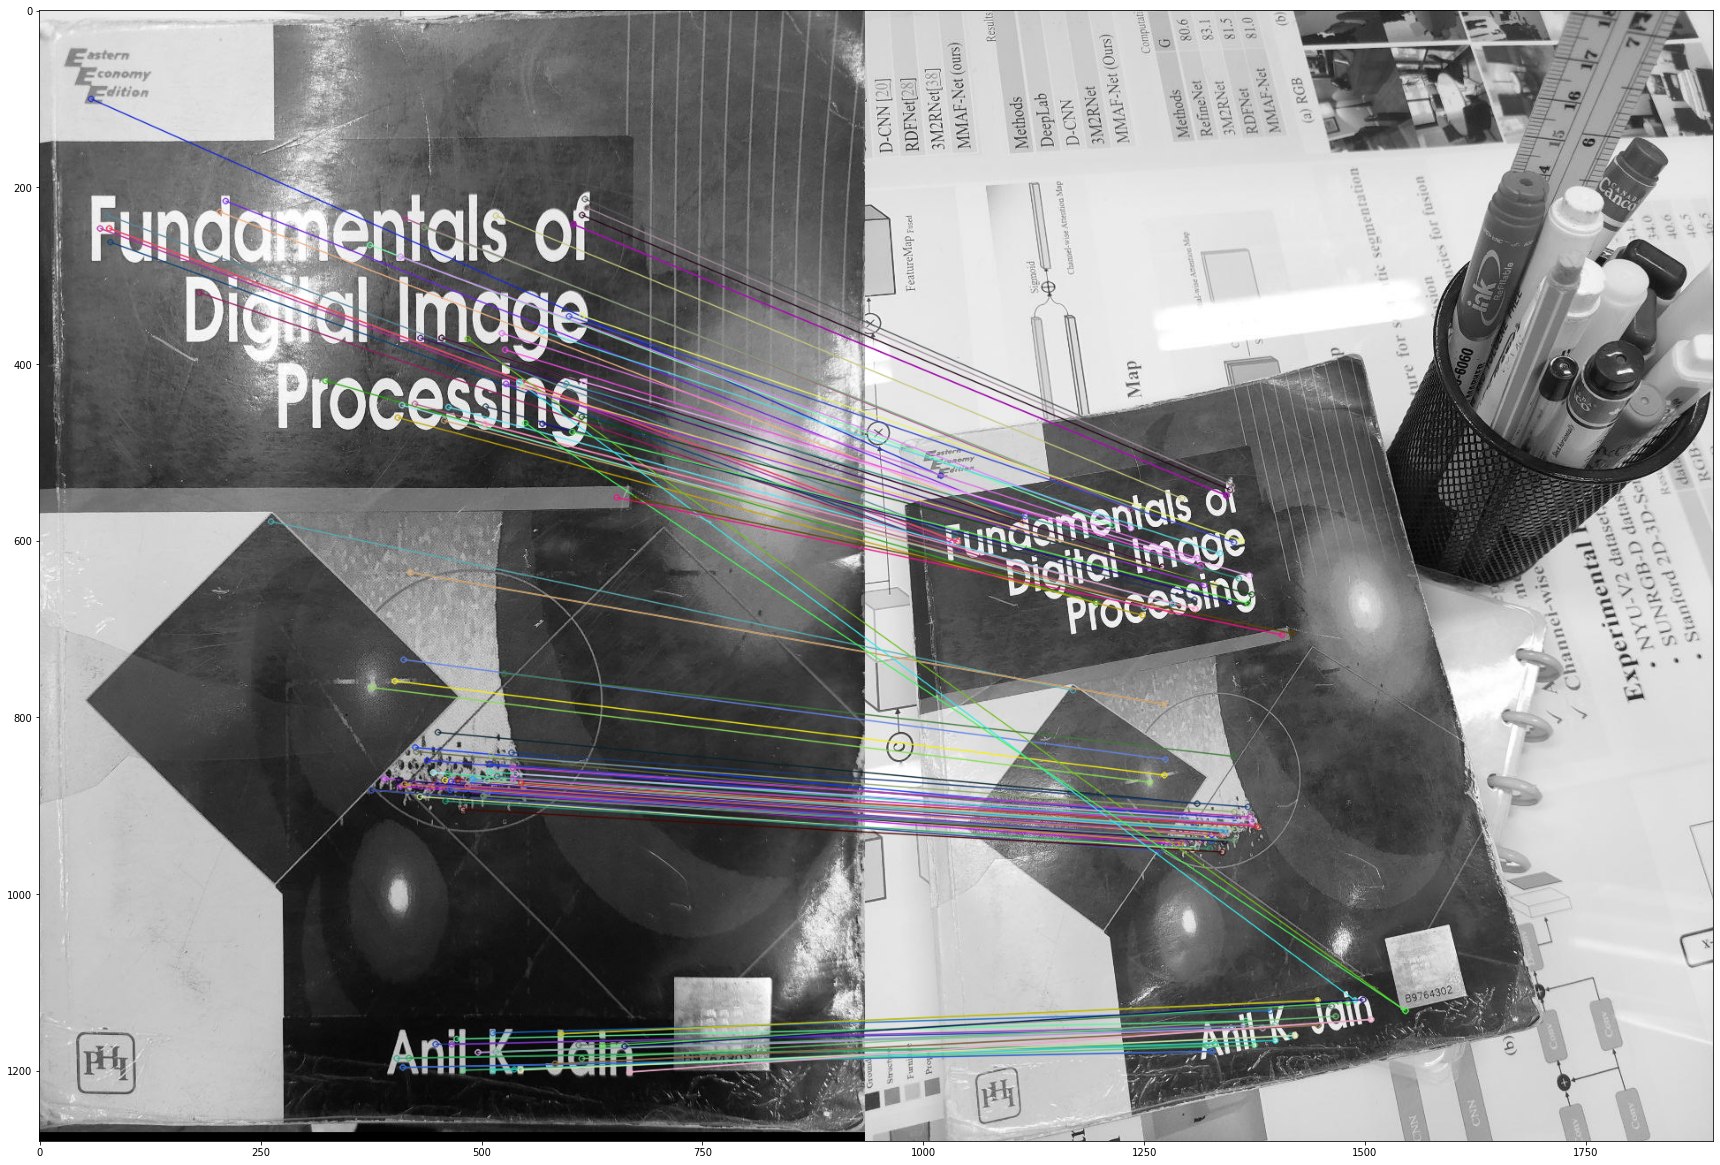

(<matplotlib.image.AxesImage at 0x1695c6da0>, None)

In [188]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

img1 = cv.imread('template.jpg',cv.IMREAD_GRAYSCALE)          
img2 = cv.imread('img4.jpg',cv.IMREAD_GRAYSCALE) 


sift = cv.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

good = []
for m,n in matches:
    if m.distance < 0.4*n.distance:
        good.append([m])
        
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
fig = plt.figure(figsize=(30, 40))
plt.imshow(img3),plt.show()